## DASCI 212: Group Exercise 2
An Exploratory Data Analysis on COVID-19 Clinical Trials 
<br>
<br> Co, Julie Anne 
<br> Del Valle, Julius Kevin
<br> Tallo, Francis 
<br> Zornosa, Dave

---

In this EDA, we explore a subset of COVID-19 clinical trials, sourced from **[ClinicalTrials.gov](https://www.clinicaltrials.gov/)**. These studies, conducted with human volunteers, aim to evaluate the effects of specific interventions according to the research plan or protocal designed by the investigators. 

---

Before we begin, we will first import the necessary packages for our analysis.

In [1]:
pip install pycountry pandarallel pendulum nltk

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry
from pandarallel import pandarallel
import nltk
import pendulum
from collections import Counter
import numpy as np
import warnings
from wordcloud import WordCloud, STOPWORDS
from helpers import categorical_summ, age_clean, explode_dict, days_between, date_convert, countries, counter_dict, counter_df
pandarallel.initialize(progress_bar = True)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Next, we load our COVID dataset into a dataframe. we have a total of 5,783 studies included in this dataset with 27 columns containing information about the study type, status, topics, participants, as well as dataes and links.

In [38]:
df = pd.read_csv('covid.csv')
print(df.shape)
df.head(5)

(5783, 27)


,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,All,"18 Years and older (Adult, Older Adult)",Not Applicable,1000.0,Other,Interventional,Allocation: N/A|Intervention Model: Single Gro...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,All,"18 Years and older (Adult, Older Adult)",Phase 1|Phase 2,60.0,Other,Interventional,Allocation: Randomized|Intervention Model: Par...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,All,"18 Years and older (Adult, Older Adult)",NaN,500.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
3,4,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,All,"Child, Adult, Older Adult",NaN,2500.0,Industry,Observational,Observational Model: Cohort|Time Perspective: ...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
4,5,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,Female,18 Years to 48 Years (Adult),NaN,50.0,Other,Observational,Observational Model: Cohort|Time Perspective: ...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924


### Data Cleaning and Transformations
Before doing any EDA, we will be cleaning certain categorical columns. This will be done thorugh text transformations and binning certain minor groups together.
<br> <b> Binning Data

In [39]:
df['Study Type'] = np.where(df['Study Type'].isin(['Interventional', 'Observational']), df['Study Type'], 'Expanded Access')
df['Funded By (Binned)'] = np.where(df['Funded Bys'].isin(['Other', 'Industry']), df['Funded Bys'], 'NIH, U.S. Fed, Industry, and/or Others')
df['Age (Group)'] = df['Age'].parallel_apply(age_clean)
df['Has Results'] = np.where(df['Study Results'] == 'No Results Available', 0, 1)
df['Posted Results'] = np.where(df['Results First Posted'].isna(), 0, 1)
df['Study Design (Dict)'] = df['Study Designs'].parallel_apply(explode_dict)

We will also be standardizing date columns so we can derive duration variables.
<br> <b>Date Cleaning

In [41]:
df['Start Date'] = df['Start Date'].parallel_apply(date_convert)
df['Primary Completion Date'] = df['Primary Completion Date'].parallel_apply(date_convert)
df['Completion Date'] = df['Completion Date'].parallel_apply(date_convert)
df['First Posted'] = df['First Posted'].parallel_apply(date_convert)
df['Last Update Posted'] = df['Last Update Posted'].parallel_apply(date_convert)

df['Study Duration (Primary)'] = df.parallel_apply(days_between, args = ('Start Date', 'Primary Completion Date',),axis = 1)
df['Study Duration (Completion)'] = df.parallel_apply(days_between, args = ('Start Date', 'Completion Date',) ,axis = 1)
df['Days til Completion'] = df.parallel_apply(days_between, args = ('today', 'Completion Date',), axis = 1)
df['Days since Update'] = df.parallel_apply(days_between, args = ('Last Update Posted', 'today',), axis = 1)
df['Days since Started'] = df.parallel_apply(days_between, args = ('Start Date', 'today',), axis = 1)


We will also extract the countries from the Locations column. We will use the PyCountry library to deternine all the countries invloved in each study. 
<br> <b> Country Extraction

In [7]:
df['Countries'] = df.parallel_apply(countries, axis = 1)
df['No of Countries'] = df['Countries'].parallel_apply(lambda x: len(x))

In [8]:
shape = len(df)

That is all for our data cleaning. Now that we are done with the necessary data preparation, we will begin our EDA.

---

### Exploratory Data Analysis (COVID CLINICAL STUDIES)
A total of 5,783 studies are included in the COVID Clinical Studies Dataset. These were majorly (96%) conducted from 2020 onwards. However, some relevant researchers that span as early as 1998 were also included, like the example below:


In [20]:
df[df['Start Date'] == '1998-01-01']

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,Gender,Age,Phases,Enrollment,Funded Bys,Study Type,Study Designs,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL,Funded By (Binned),Age (Group),Interventions (Dict),Has Results,Posted Results,Study Duration (Primary),Study Duration (Completion),Days til Completion,Days since Update,Days since Started,Countries,No of Countries
5305,5306,NCT04322786,The Use of Angiotensin Converting Enzyme Inhib...,NaN,"Active, not recruiting",No Results Available,"Covid-19, Coronavirus, Angiotensin Converting ...",Drug: ACE inhibitor,Incidence of influenza,"University College, London",All,"18 Years and older (Adult, Older Adult)",NaN,1302508.0,Other,Observational,Observational Model: Case-Control|Time Perspec...,ISAC17_205R,1998-01-01,2016-05-31,2021-03-31,2020-03-26,NaN,2020-11-13,NaN,NaN,https://ClinicalTrials.gov/show/NCT04322786,Other,"Adult, Older Adult",{'Drug': ['ACE inhibitor']},0,0,6725.0,8490.0,NaN,1196,9548.0,[],0


Around 57% of the trials in the dataset are interventional studies, 42% are observational studies, and the rest are expanded access.
* **Interventional:** Participants are grouped based on the interventions/treatment received vs no intervention. These aims to evaluate the effects of the intervention on either biomedical or health-related outcomes. The assignments are determined by the research design.
* **Observational:** Participants are identified as belonging to a astudy groups and assessed for biomedical or health outcomes. They may receive interventions but they are not assigned/grouped to specific interventions.
* **Expanded Access:** Also called compassionate use, these are for patients with serious conditions who are given access to to medical products that may have not yet been approved by the US FDA.

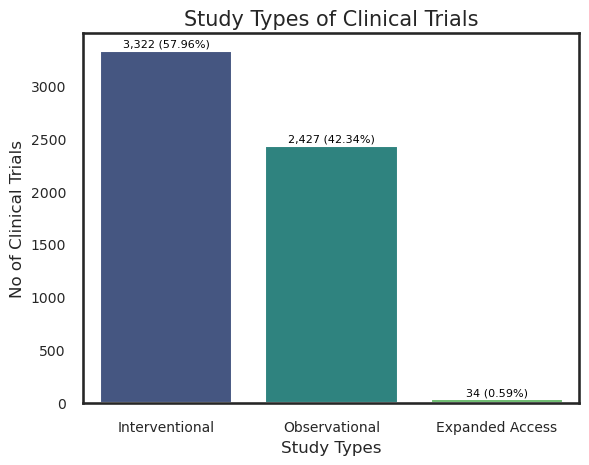

In [234]:
type_freq = pd.DataFrame(df.groupby('Study Type').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count'))).sort_values(by = 'count', ascending = False).reset_index()
type_freq['perc_total'] = type_freq['count']/sum(type_freq['count'])

type_freq['count'] = type_freq['count'].astype(int)

f, ax = plt.subplots()

# Plot the total crashes
#sns.set_color_codes("pastel")
sns.barplot(x="Study Type", y="count", data=type_freq,
            label="Total", palette = 'viridis')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
ax.set_xlabel('Study Types', fontsize = 12)
plt.title('Study Types of Clinical Trials', fontsize = 15)
ax.set_ylabel('No of Clinical Trials', fontsize = 12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f} ({p.get_height()/5732:,.2%})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points');

On the other hand, 50% of the studies are still on 'Recruiting' status. In fact, 96% of these studies are already overdue, meaning that their expected completion date has already passed and yet they are still not in 'Completed' status. The last known update from these unfinished studies are on average from 3 years ago.

In [236]:
statusp_freq = pd.pivot_table(df, values=['Status', 'Phases'])
status

,Status,Phases,count,results
0,Recruiting,Not Applicable,647,0
1,Recruiting,Phase 2,343,0
2,Not yet recruiting,Not Applicable,282,0
3,Completed,Not Applicable,226,6
4,Recruiting,Phase 3,196,0
...,...,...,...,...
57,Suspended,Phase 4,2,0
58,Suspended,Phase 1|Phase 2,2,0
59,Suspended,Early Phase 1,2,0
60,Enrolling by invitation,Phase 2|Phase 3,1,0


In [208]:
df['Overdue'] = np.where((df['Status'] != 'Completed') & (df['Completion Date'] < pendulum.now().to_date_string()),1,0)
recruit = df[df['Status'].isin(['Recruiting', 'Not yet recruiting', 'Active, not recruiting'])].groupby('Status').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')
                                ,overdue = pd.NamedAgg(column = 'Overdue', aggfunc = 'sum')
                                ,avg_days_since_upd = pd.NamedAgg(column = 'Days since Update', aggfunc = 'median')).sort_values(by = 'count', ascending = False)
recruit['avg_months_since_upd'] = recruit['avg_days_since_upd']/30
recruit['perc_overdue'] = recruit['overdue']/recruit['count']
recruit[['count', 'overdue', 'perc_overdue', 'avg_months_since_upd']]

,count,overdue,perc_overdue,avg_months_since_upd
Status,,,,
Recruiting,2805,2677,0.954367,38.666667
Not yet recruiting,1004,966,0.962151,39.200000
"Active, not recruiting",526,513,0.975285,37.266667


---

### Geographic Location
The study was administered in 144 countries, with the United States of America and France being the top countries. Most of the studies focused on the American and European demographic. Only less than 5% of the studies were administered to the Asian countries.

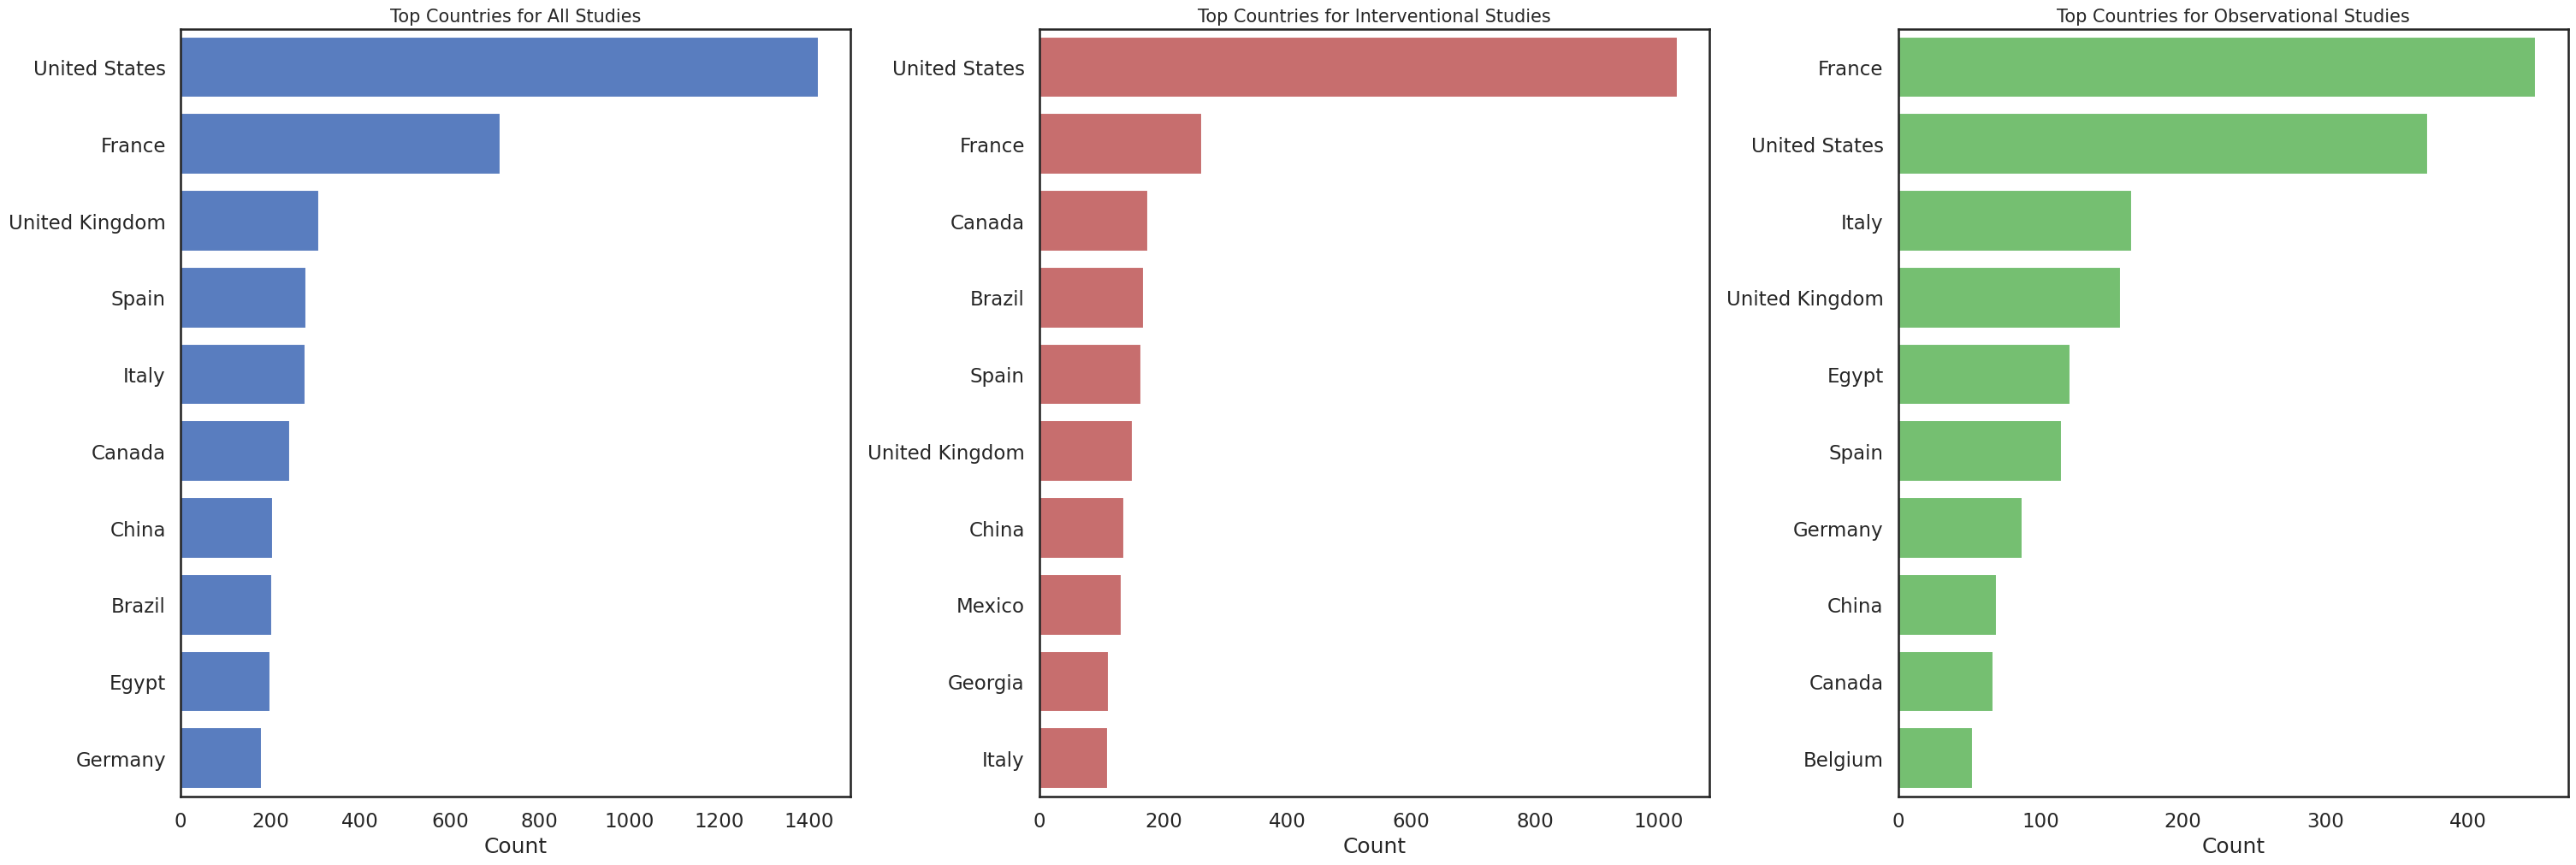

In [250]:
#Dataset for Total Studies
total_countries = counter_df(df['Countries'], 'Countries')
total_countries['perc_total'] = total_countries['Count']/len(df)

#Dataset for Interventional Studies
int_countries = counter_df(df[df['Study Type'] == 'Interventional']['Countries'], 'Countries')
int_countries['perc_total'] = int_countries['Count']/len(df[df['Study Type'] == 'Interventional'])


#Dataset for Observational Studies
obs_countries = counter_df(df[df['Study Type'] == 'Observational']['Countries'], 'Countries')
obs_countries['perc_total'] = obs_countries['Count']/len(df[df['Study Type'] == 'Observational'])


f, (ax1, ax2, ax3)= plt.subplots(1,3, figsize = (30, 10), constrained_layout  = True)

#ns.lineplot(x, y, ax=ax2, color='red')
#ax2.set_title('Seaborn Plot')

#total_colors = []


sns.barplot(x="Count", y="Countries", data=total_countries.head(10),
            label="Top Countries for All Studies", ax = ax1, color = 'b');
ax1.set_title('Top Countries for All Studies', fontsize = 15);
ax1.set_ylabel(None)

sns.barplot(x="Count", y="Countries", data=int_countries.head(10),
             ax = ax2, color = 'r');
ax2.set_title('Top Countries for Interventional Studies', fontsize = 15);
ax2.set_ylabel(None)

sns.barplot(x="Count", y="Countries", data=obs_countries.head(10),
             ax = ax3, color = 'g');
ax3.set_title('Top Countries for Observational Studies', fontsize = 15);

ax3.set_ylabel(None);

## Age Group
More than 80% of the studies focused on the adult and older adults demographic. This is because of the cited higher risk of severe symptoms and death amongst older adults. Children, on the other hand are supposed to have milder symptoms and even asymptomatic which makes them the less ideal demographic for COVID studies.

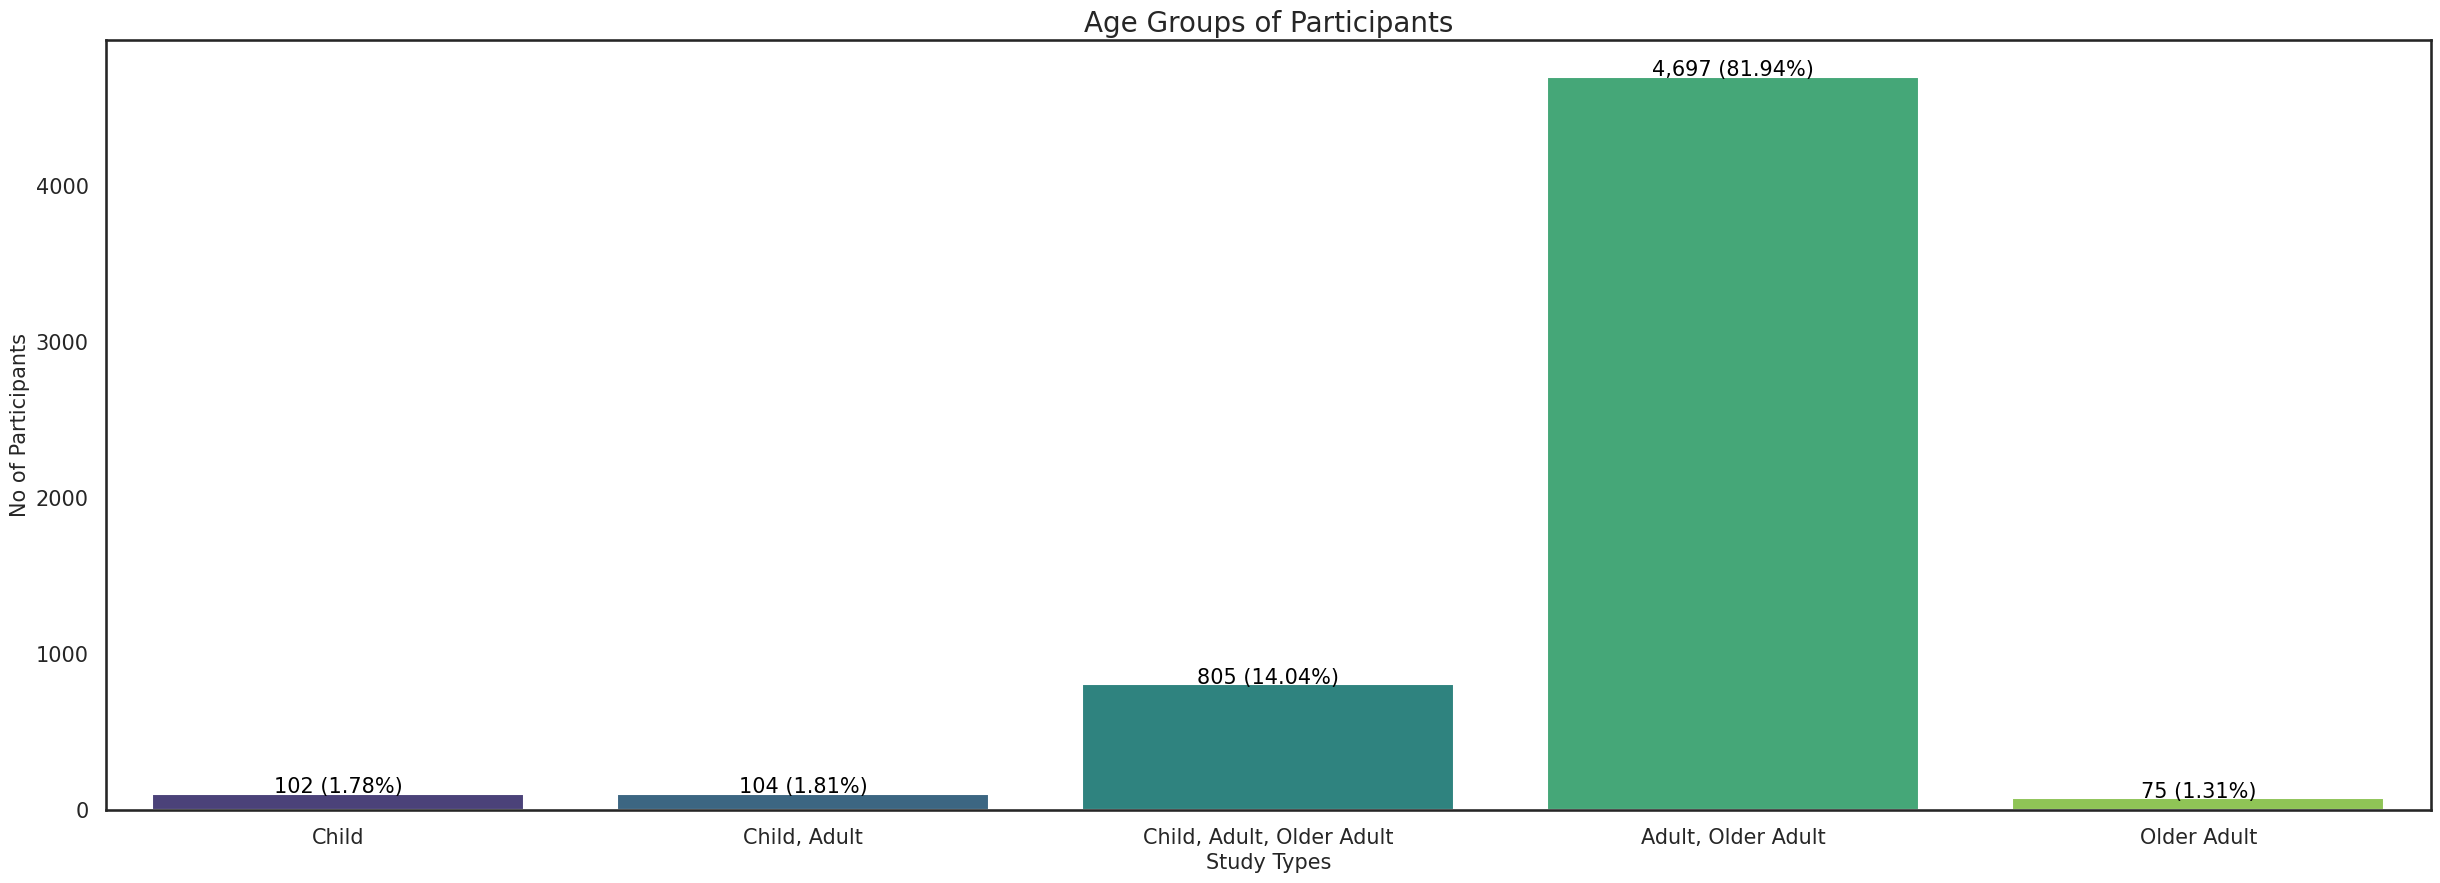

In [279]:
df['Age Group v2'] = np.where(df['Age (Group)']=='Adult', 'Adult, Older Adult', df['Age (Group)'])
age_freq = pd.DataFrame(df.groupby('Age Group v2')['NCT Number'].count().sort_values(ascending = False)).reset_index()
age_freq.columns = ['Age Group', 'count']
age_freq['perc_total'] = age_freq['count']/len(df)
age_freq = age_freq.loc[[3,2,1,0,4]]

f, ax = plt.subplots(1,1, figsize = (30, 10))

sns.barplot(x="Age Group", y="count", data=age_freq,
            label="Total", palette = 'viridis')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_xlabel('Study Types', fontsize = 15)
plt.title('Age Groups of Participants', fontsize = 20)
ax.set_ylabel('No of Participants', fontsize = 15)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f} ({p.get_height()/5732:,.2%})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=15, color='black', xytext=(0, 5), 
                textcoords='offset points');

### Top Interventions

In [191]:
int_type = counter_dict(df['Interventions (Dict)'], 'Intervention Type')
int_type['perc_total'] = int_type['Count']/len(df)
int_type.head(10)

,Intervention Type,Count,perc_total
1,Drug,1626,0.281169
2,Other,1607,0.277883
3,Biological,627,0.108421
0,Diagnostic Test,527,0.091129
4,Behavioral,503,0.086979
6,Device,338,0.058447
8,Procedure,148,0.025592
7,Dietary Supplement,126,0.021788
9,Combination Product,47,0.008127
10,Radiation,24,0.004150


In [192]:
int_spec = counter_dict(df['Interventions (Dict)'], 'Intervention Type', keys = False)
int_spec['perc_total'] = int_spec['Count']/len(df)
int_spec.head(10)

,Intervention Type,Count,perc_total
27,Placebo,579,0.100121
151,Hydroxychloroquine,104,0.017984
228,Remdesivir,45,0.007781
87,Standard of Care,44,0.007609
1013,Tocilizumab,39,0.006744
907,Azithromycin,39,0.006744
293,Questionnaire,37,0.006398
48,Standard of care,33,0.005706
209,No intervention,32,0.005533
267,Placebo oral tablet,32,0.005533


In [ ]:
df.groupby

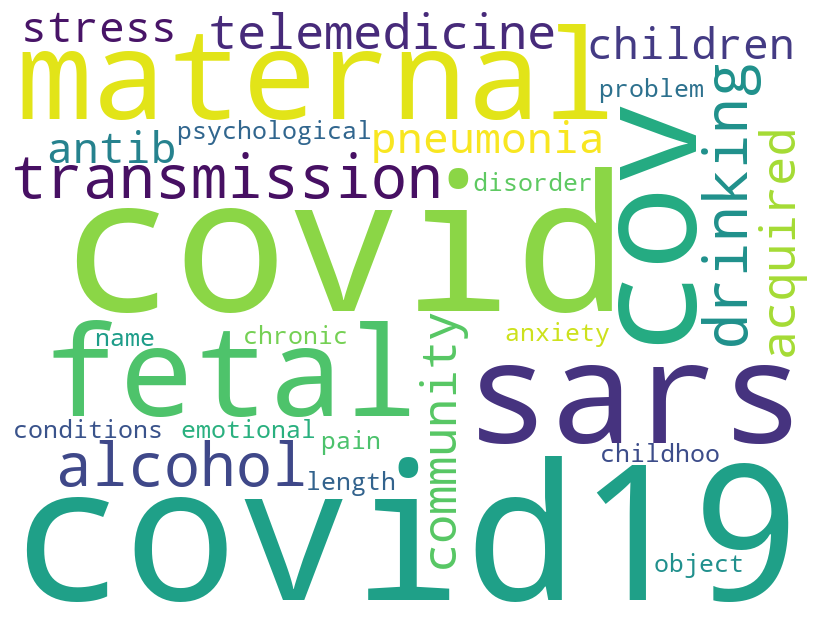

In [221]:
stopwords = list(STOPWORDS)
stopwords += ['mind', 'performance', 'infection', 'dtype']
wordcloud = WordCloud(width = 800, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(str(df['Conditions']).lower())
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [217]:
pd.DataFrame(df.groupby('Funded By (Binned)')['NCT Number'].count().sort_values(ascending =False))

,NCT Number
Funded By (Binned),
Other,4488
Industry,651
"NIH, U.S. Fed, Industry, and/or Others",644


### Status of the Studies
Out of all the ~6,000 studies, only **around 10% of the studies have been completed** -- meaning that they have ended normally and participants are no longer being treated or examined. However, only 33 studies out of the 1,025 (3%) completed studies have posted their results. This is an extremely low publish rate and based on the nature of the website, could arguably be either because of:
- Incorrect Information on Study status
- Outdated Records hence the lack of results <br>

Either way, the status of these studies should be revisited in order to ensure accuracy and uphold the purpose of ClinicalTrials.gov to make clinical research studies accessible to the public.

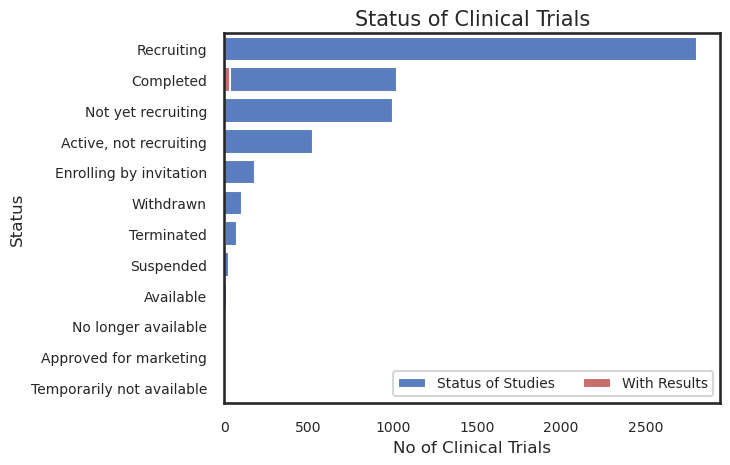

In [181]:
status_freq = pd.DataFrame(df.groupby('Status').agg(count = pd.NamedAgg(column = 'NCT Number', aggfunc = 'count')
                                                    ,results = pd.NamedAgg(column = 'Has Results', aggfunc = 'sum'))).sort_values(by = 'count', ascending = False).reset_index()
status_freq['perc_total'] = status_freq['count']/sum(status_freq['count'])
status_freq

# Initialize the matplotlib figure
f, ax= plt.subplots()

# Plot the total crashes
sns.barplot(x="count", y="Status", data=status_freq,
            label="Status of Studies", color  = 'b')

sns.set_color_codes("muted")
sns.barplot(x="results", y="Status", data=status_freq,
            label="With Results", color="r")

ax.legend(ncol=2, loc="lower right", frameon=True, fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
ax.set_xlabel('No of Clinical Trials', fontsize = 12)
plt.title('Status of Clinical Trials', fontsize = 15)
ax.set_ylabel('Status', fontsize = 12);